<a href="https://colab.research.google.com/github/DhilipSanjay/Detection-of-Sensitive-Data-Exposure-in-Images/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import os

git_folder = "/content/Detection-of-Sensitive-Data-Exposure-in-Images"
if os.path.exists(git_folder) == False:
  !git clone https://github.com/DhilipSanjay/Detection-of-Sensitive-Data-Exposure-in-Images.git

training_folder = git_folder + "/dataset/training"
validation_folder = git_folder + "/dataset/validation"

Cloning into 'Detection-of-Sensitive-Data-Exposure-in-Images'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 777 (delta 7), reused 46 (delta 5), pack-reused 726
Receiving objects: 100% (777/777), 82.58 MiB | 33.15 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [5]:
train_sensitive_dir = os.path.join(training_folder + "/sensitive")
train_nonsensitive_dir = os.path.join(training_folder + "/nonsensitive")
validation_sensitive_dir = os.path.join(validation_folder + "/sensitive")
validation_nonsensitive_dir = os.path.join(validation_folder + "/nonsensitive")

print('Total training sensitive images:', len(os.listdir(train_sensitive_dir)))
print('Total training nonsensitive images:', len(os.listdir(train_nonsensitive_dir)))
print('Total validation sensitive images:', len(os.listdir(validation_sensitive_dir)))
print('Total validation nonsensitive images:', len(os.listdir(validation_nonsensitive_dir)))

Total training sensitive images: 300
Total training nonsensitive images: 300
Total validation sensitive images: 50
Total validation nonsensitive images: 50


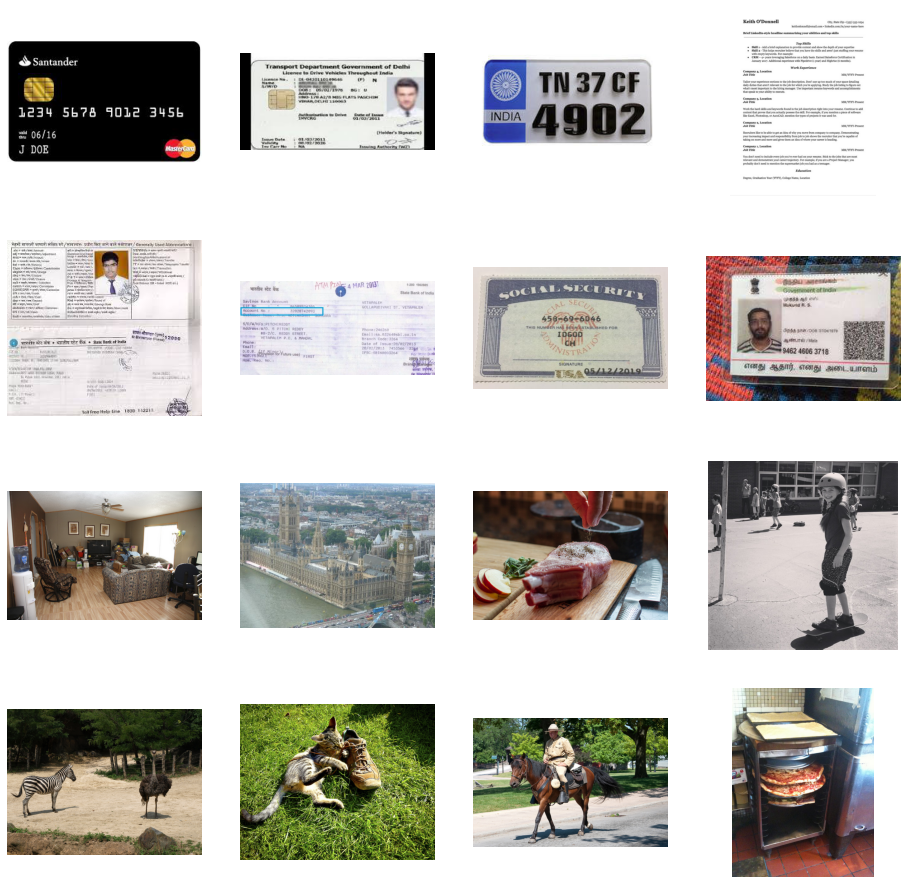

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

train_sensitive_dir = os.path.join(training_folder+"/sensitive")
train_nonsensitive_dir = os.path.join(training_folder+"/nonsensitive")
train_sensitive_names = os.listdir(train_sensitive_dir)
train_nonsensitive_names = os.listdir(train_nonsensitive_dir)

pic_index += 8
next_sensitive_pix = [os.path.join(train_sensitive_dir, fname) 
                for fname in train_sensitive_names[pic_index-8:pic_index]]
next_nonsensitive_pix = [os.path.join(train_nonsensitive_dir, fname) 
                for fname in train_nonsensitive_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_sensitive_pix+next_nonsensitive_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [7]:
DESIRED_ACCURACY = 0.999

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 16)        2

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        training_folder,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary'
       )

validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary'
        )

history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8
      ) #callbacks=[callbacks]

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/15
5/5 [==============================] - 1s 313ms/step - loss: 0.8185 - accuracy: 0.5533 - val_loss: 0.6864 - val_accuracy: 0.5000
Epoch 2/15
5/5 [==============================] - 2s 346ms/step - loss: 0.6618 - accuracy: 0.5933 - val_loss: 0.6764 - val_accuracy: 0.4250
Epoch 3/15
5/5 [==============================] - 1s 321ms/step - loss: 0.6601 - accuracy: 0.5533 - val_loss: 0.7520 - val_accuracy: 0.4250
Epoch 4/15
5/5 [==============================] - 1s 274ms/step - loss: 0.6571 - accuracy: 0.5667 - val_loss: 0.5744 - val_accuracy: 0.9250
Epoch 5/15
5/5 [==============================] - 1s 305ms/step - loss: 0.7508 - accuracy: 0.6467 - val_loss: 0.6073 - val_accuracy: 0.6250
Epoch 6/15
5/5 [==============================] - 2s 331ms/step - loss: 0.5901 - accuracy: 0.7400 - val_loss: 0.6809 - val_accuracy: 0.4750
Epoch 7/15
5/5 [==============================] - 2s 305ms/step - loss: 0.5636

In [10]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " - Sensitive")
  else:
    print(fn + " - Non-sensitive")

Saving task6.jpg to task6.jpg
[0.]
task6.jpg - Non-sensitive
